In [29]:
# import os
import os.path
os.environ['USE_PYGEOS'] = '0'
import xarray as xr
import numpy as np
import pandas as pd
import fiona
import glob
import dask_geopandas
import geopandas as gpd
import time
from copy import deepcopy
from functools import reduce

import aggfly
import netCDF4

import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar

from aggfly import regions
from aggfly import dataset, regions, grid_weights
from aggfly.aggregate import TemporalAggregator, SpatialAggregator
# from aggfly.aggregate import TemporalAggregator, SpatialAggregator

ProgressBar().register()
# client = Client(n_workers=2)

project_dir = '/user/gb2884/aggfly/notebooks/giovanni_example'

In [30]:
gdf = gpd.read_file("/Users/gb2884/Desktop/aggfly_loc/giovanni/aggfly/notebooks/giovanni_example/usa_simple_noHI.shp")
print(gdf.head())
gdf.plot(color='blue', legend=True)



DriverError: /Users/gb2884/Desktop/aggfly_loc/giovanni/aggfly/notebooks/giovanni_example/usa_simple_noHI.shp: No such file or directory

In [38]:
import os
import os.path

# Years to aggregate
years = np.arange(1951,2020)
years = years[years != 1959]

#georegions = regions.from_path("/Users/gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/world_example/IPUMSI_world_release2020/world_countries_2020.shp",regionid='CNTRY_CODE')
georegions = regions.from_path('/user/gb2884/aggfly/notebooks/giovanni_example/usa_simple_noHI.shp',regionid='geometry')

georegions.shp["GEOID"]=range(50)

print(georegions.shp.columns)

Index(['geometry', 'GEOID'], dtype='object')


In [39]:
print(georegions.shp.shape)
georegions

(50, 2)


In [40]:
def preprocess_era5l(array):
    # Function for cleaning the era5l data.
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):   
        # Reformat longitude
        array.coords['longitude'] = (array.coords['longitude'] + 180) % 360 - 180
        array = array.sortby(array.longitude)
        # Kelvin -> Celsius
        array = array - 273.15
    return array

# Open example dataset to construct weights.
clim = dataset.from_path(
    #f"/Users\gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/world_example/era_june_2000_2tm.nc", 
    #f"/Users/gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/IPUMS_1level_example/era_1st_June_2000_tm.nc",
    f"/user/gb2884/aggfly/notebooks/giovanni_example/era_1st_June_2000_tm.nc",
    var = 't2m',
    engine = 'netcdf4',
    name='era5',
    clip_geom=georegions,
    preprocess = preprocess_era5l)

# Calculate area and pop layer weights.
weights = grid_weights.from_objects(
    clim,
    georegions,
    wtype=None,
    simplify=0.001,
    project_dir=project_dir)


#clim.clip_data_to_georegions_extent(georegions)

print("Loading weights")
w = weights.weights()
nzw_ind = np.isin(clim.grid.index, w.cell_id).nonzero()
print(w) 
#print(nzw_ind)
#print(clim.grid.index)
#print(w.cell_id)

/user/gb2884/aggfly/notebooks/giovanni_example/tmp/GridWeights/mod-9c23708f3e79a8e
Loading weights
Loading rescaled weights from cache
Cache dictionary:
{'func': 'weights', 'raster_weights': None}
       cell_id  index_right  area_weight  longitude  latitude    weight
0         2962            1     1.000000    -157.25     70.75  1.000000
1         2963            1     1.000000    -157.00     70.75  1.000000
2         2964            1     1.000000    -156.75     70.75  1.000000
3         4392            1     1.000000    -159.00     70.50  1.000000
4         4393            1     1.000000    -158.75     70.50  1.000000
...        ...          ...          ...        ...       ...       ...
20855   267676            9     0.003363     -80.75     24.75  0.003363
20856   269107            9     0.000017     -82.25     24.50  0.000017
20857   269108            9     0.006008     -82.00     24.50  0.006008
20858   269109            9     0.060197     -81.75     24.50  0.060197
20859   269

In [41]:
print("Scheduling aggregation")
dailies = [
    TemporalAggregator('avg', 'time.date')
]
monthly = TemporalAggregator('sum', 'time.month')

Scheduling aggregation


In [42]:
out = pd.DataFrame()
#for year in years:
#    print(year)
#    start = time.time()
year = 2000

print('Loading climate data')
clim = dataset.from_path(
    #f"/Users\gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/world_example/era_june_2000_2tm.nc", 
    #f"/Users/gb2884/The Lab Dropbox/Giovanni Brocca/Macro_Enviro_Dev/1_Data/IPUMS_1level_example/era_1st_June_2000_tm.nc",
    f"/user/gb2884/aggfly/notebooks/giovanni_example/era_1st_June_2000_tm.nc",
    var = 't2m',
    engine = 'netcdf4',
    name='era5',
    clip_geom=georegions,
    preprocess = preprocess_era5l)
clim.update(clim.da.persist())

print('Aggregating')
day_ds = [x.map_execute(clim, nzw_ind) for x in dailies]
month_ds = [monthly.map_execute(x, nzw_ind) for x in day_ds]

Loading climate data
[########################################] | 100% Completed | 104.34 ms
[########################################] | 100% Completed | 207.17 ms
[########################################] | 100% Completed | 303.50 ms
[########################################] | 100% Completed | 402.11 ms
[########################################] | 100% Completed | 404.34 ms
[########################################] | 100% Completed | 503.42 ms
[########################################] | 100% Completed | 604.64 ms
Aggregating


In [43]:
names = ['avg']
df = SpatialAggregator(day_ds, w, weights.grid, names=names).compute()
    
# Clean output dataset and append
df = df.reset_index().rename(columns={'time':'month'})
df['year'] = year
df = df[['region_id', 'year', 'month'] + names]
df = georegions.shp[['GEOID']].merge(df, left_index=True, right_on='region_id')

out = pd.concat([out, df])

[########################################] | 100% Completed | 105.00 ms
[########################################] | 100% Completed | 202.36 ms
[########################################] | 100% Completed | 301.87 ms
[########################################] | 100% Completed | 304.57 ms
[########################################] | 100% Completed | 404.24 ms
[########################################] | 100% Completed | 505.24 ms
[########################################] | 100% Completed | 604.69 ms
[########################################] | 100% Completed | 1.16 sms
[########################################] | 100% Completed | 1.19 s
[########################################] | 100% Completed | 1.28 s
[########################################] | 100% Completed | 1.29 s
[########################################] | 100% Completed | 1.38 s
[########################################] | 100% Completed | 1.47 s
[########################################] | 100% Completed | 1.48 s


In [44]:
out.reset_index().to_feather("/home3/dth2133/data/clim_data_requests/maya/temp_data_maya.feather")

OSError: Cannot save file into a non-existent directory: '/home3/dth2133/data/clim_data_requests/maya'

Matplotlib is building the font cache; this may take a moment.


<Axes: >

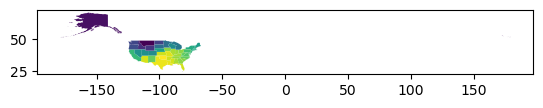

In [45]:
slc = out.loc[out.year==2000].groupby('GEOID').mean()
georegions.shp.merge(slc, right_index=True, left_on='GEOID').plot(column='avg')

In [ ]:
print(georegions.shp.columns)
print(slc["avg"])